In [1]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline
import numpy as np
import tensorflow as tf
import random as python_random
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

## Neural Network

In this notebook, we will work with the qm7b data.

In [2]:
qm7b = pd.read_csv('http://faculty.washington.edu/tingcao/wordpress/wp-content/uploads/2020/10/qm7b.csv');
qm7b.head()

,id,ae_pbe0,emax_zindo,imax_zindo,homo_zindo,lumo_zindo,e1_zindo,ip_zindo,ea_zindo,homo_pbe0,...,homo_gw,lumo_gw,p_pbe0,p_scs,n_H,n_C,n_N,n_O,n_S,n_Cl
0,1,-420.933746,39.694626,0.621841,-16.013,4.162,36.768073,15.72523,-3.98613,-10.9488,...,-14.1341,1.0870,2.534576,2.43222,4,1,0,0,0,0
1,2,-718.419189,22.622486,0.628328,-13.549,3.684,11.717433,13.41121,-3.49181,-9.5577,...,-12.5472,1.1186,4.332028,4.44500,6,2,0,0,0,0
2,3,-570.024841,22.940671,0.709060,-10.160,1.231,7.137266,9.75211,-0.82042,-7.8768,...,-10.4383,1.9456,4.173282,3.92308,4,2,0,0,0,0
3,4,-410.286163,15.973798,2.228480,-10.706,2.145,4.624107,10.46577,-1.89847,-8.4021,...,-11.1629,1.1958,3.512394,3.32175,2,2,0,0,0,0
4,5,-868.855408,17.900516,0.556174,-12.365,3.825,10.311655,11.96491,-3.57487,-8.3534,...,-10.8132,1.2002,5.480160,5.78632,6,3,0,0,0,0


Let our predictors be 'homo_zindo', 'lumo_zindo', target be 'e1_zindo' (first excitation energy).

Do the train-test splitting first.

In [3]:
x = qm7b[['homo_zindo', 'lumo_zindo']].values
y = qm7b['e1_zindo'].values
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.20)

In [4]:
np.min(y)

1.516286787

In [5]:
np.max(y)

36.7680730972

In [6]:
x_train.shape

(5768, 2)

## Data Standardization

The `StandardScaler` standardize the data by: $X_i = \frac{X_i - \mu _i}{\sigma _i}$,

$X_i$ is the $i$-th feature, $\mu_i$ is the mean value of the feature $i$ in the training data, $\sigma_i$ is the variance of the feature $i$ in the training data.

In [7]:
scaler = StandardScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

Histogram before normalization:

(array([ 15.,  53., 137., 266., 271., 285.,  48.,  73., 261.,  34.]),
 array([-2.084 , -1.4923, -0.9006, -0.3089,  0.2828,  0.8745,  1.4662,
         2.0579,  2.6496,  3.2413,  3.833 ]),
 <BarContainer object of 10 artists>)

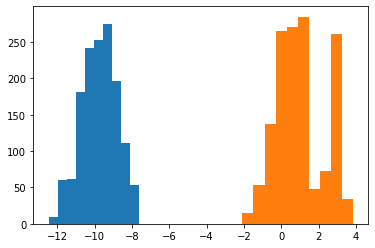

In [8]:
plt.hist(x_test[:,0])
plt.hist(x_test[:,1])

Histogram after normalization:

(array([ 15.,  53., 137., 266., 271., 285.,  48.,  73., 261.,  34.]),
 array([-2.39842629, -1.94652113, -1.49461598, -1.04271082, -0.59080566,
        -0.13890051,  0.31300465,  0.76490981,  1.21681496,  1.66872012,
         2.12062528]),
 <BarContainer object of 10 artists>)

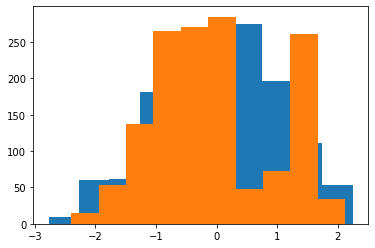

In [9]:
plt.hist(x_test_norm[:,0])
plt.hist(x_test_norm[:,1])

## Train and test neural network

We construct a neural network model with one input layer, one hidden layer and one output layer, and wrap it in a function.

The picture below illustrates the structure of neural network:

<img width="512" alt="NN" src="https://www.astroml.org/_images/fig_neural_network_1.png"></a>


Here we set each layer in the neural network to be `dense` layer. A `Dense` function implements the operation: `output = activation(dot(input, kernel) + bias)` 

where `activation` is the element-wise activation function passed as the activation argument (shown as $f(),g()$ in the picture), `kernel` is a weights matrix created by the layer (shown as $w_{ij}, w_{jk}$ in the picture), and `bias` is a bias vector created by the layer (shown as $b_j,b_k$ in the picture).


In [10]:
#Define a neural network model, and wrap this model in a function
def nnmodel1():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

After we define the neural network model, we will need to train it.

* `epochs`: specify the number of epochs. In each epoch, ALL the training data will be propagated through the network once.
* `batch_size`: the number of samples that will be propagated through the network in a batch. The weights in the network will be updated after each batch (this might depend the optimization algorithm you choose).
* `validation_split`: split the given ratio of training data into validation data, the rest is training data. Note that only the training data will be used to train the model, the validation data is just used for evaluate the accuracy of the model after each epoch. 

The overall process of training:

    For each epoch:
        For each batch:
            For each training data in the batch:
                propagate through the network
            Update the weights
            Get the accuracy of training dataset
        For each validation data in the batch:
            Get the accuracy of validation dataset
            

In [11]:
estimator = KerasRegressor(build_fn=nnmodel1) #nnmodel1 is the neural network model we defined above
history = estimator.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

2022-11-20 21:26:27.371554: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 21:26:27.461319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-20 21:26:27.462144: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


After we train the model, we can plot the train and validation error in each epoch of training. This plot is called `learning curve`.

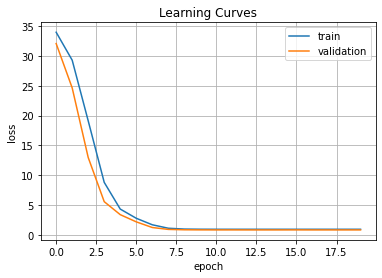

In [12]:
plt.plot(range(20),history.history['loss'])
plt.plot(range(20),history.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

The learning curve can be used to diagnose if the model is `Good fit`,`Under fit` or `Over fit`. It can indicate a `Good fit` if the training curve decreases to a point of stability and have a stable gap with the validation curve. A `Over fit` can be inferred if the training curve constantly decreases while the validation curve remains flat or even increases. A `Under fit` can be identified if the training curve is decreasing and continues to decrease at the end of the training process.

In [13]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

final MSE for train is 0.91 and for validation is 0.80


Test the neural network:

In [14]:
test_loss = estimator.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss)

46/46 [==============================] - 0s 668us/step - loss: 0.7532
test set mse is 0.75


Predict with the neural network:

In [15]:
y_test_predict = estimator.predict(x_test_norm)

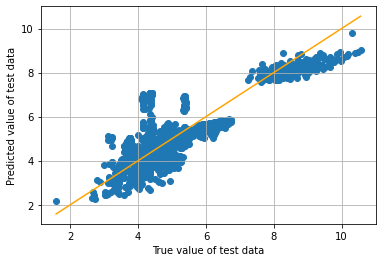

In [16]:
plt.scatter(y_test, y_test_predict)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

## Tune the neural network

### Tune the activation function

Three types of activation functions `ReLu` `Sigmoid` and `Tanh` are plotted below. By using different activation functions in different layers, you could allow the model to have more complex mappings between the inputs and outputs.

A full list of available activation functions in Keras can be found here: https://keras.io/api/layers/activations/ .

In our example, you can set the activation function of each layer by the parameter `activation` in the `Dense()` function. 

(-5.0, 5.0, -1.2, 1.2)

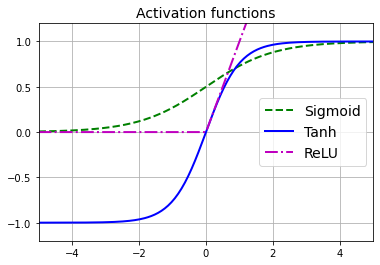

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")

plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

### Exercise 1: 
Please define a new neural network model by simply changing the parameter `activation` in the HIDDEN LAYER of the `nnmodel1()` from `relu` to another activation function of your choice, and do the train,test again.
Is your result improved compared to `nnmodel1()` in terms of test error?

In [18]:
#Define a neural network model, and wrap this model in a function
def nnmodel2():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [19]:
estimator2 = KerasRegressor(build_fn=nnmodel2) #nnmodel2 is the neural network model we defined above
history2 = estimator2.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

In [20]:
history2.history

{'loss': [32.67377853393555,
  20.168298721313477,
  7.782874584197998,
  3.007430076599121,
  1.8487056493759155,
  1.5895626544952393,
  1.4697343111038208,
  1.3877441883087158,
  1.3174033164978027,
  1.2462403774261475,
  1.1882386207580566,
  1.1392533779144287,
  1.0986837148666382,
  1.067644476890564,
  1.0450196266174316,
  1.0271638631820679,
  1.0142441987991333,
  1.0039405822753906,
  0.995215654373169,
  0.9882094264030457],
 'val_loss': [27.869239807128906,
  12.190694808959961,
  4.2725138664245605,
  1.8988878726959229,
  1.4823429584503174,
  1.3381413221359253,
  1.2508388757705688,
  1.185085415840149,
  1.1179471015930176,
  1.0565102100372314,
  1.0074405670166016,
  0.9655890464782715,
  0.9305812120437622,
  0.9044722318649292,
  0.8863223791122437,
  0.874740481376648,
  0.8630314469337463,
  0.856151282787323,
  0.8472375273704529,
  0.8441983461380005]}

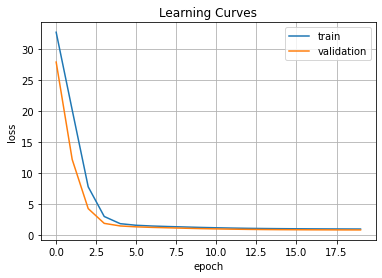

In [21]:
plt.plot(range(20),history2.history['loss'])
plt.plot(range(20),history2.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [22]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history2.history['loss'][-1], history2.history['val_loss'][-1]))

final MSE for train is 0.99 and for validation is 0.84


In [23]:
test_loss = estimator2.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss)

46/46 [==============================] - 0s 686us/step - loss: 0.7940
test set mse is 0.79


In [24]:
y_test_predict2 = estimator2.predict(x_test_norm)

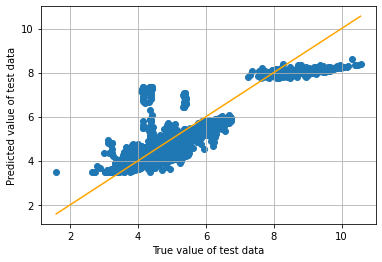

In [25]:
plt.scatter(y_test, y_test_predict2)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

Compared to the previous model with hidden layer activation relu, changing the hidden layer activation function to tanh gave a worse result based on the MSE values of the training, validation and testing sets. The tanh function might not be suitable for this dataset.

### Tune learning rate of the optimizer

The training of neural network can be regarded as an optimization process of searching the minimum of the loss function. Imagine you're searching a fastest way of going down a mountain (i.e. searching the 'minimum' of the mountain), one strategy you can take is going along the direction with the steepest descent of height. And after going one step in that direction, you need to determine the new steepest descent since your location is updated. This is basically the main idea of the optimization algorithm, and the size of the step you take in each time of updating the location is called `learning rate`.

<img width="512" alt="Trajectory towards local minimum" src="https://miro.medium.com/max/1400/1*70f9PB-RwFaakqD6lfp4iw.png"></a>

The `Adam` optimization we use here is a stochastic gradient descent method. The learning rate can be specified by the parameter `lr` in the `keras.optimizers.Adam()`. The default value is 0.001, let's change it to 0.1.

For all the available optimizers in Keras, please see this page: https://keras.io/api/optimizers/

In [26]:
def nnmodel3():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    optimizer = keras.optimizers.Adam(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [27]:
estimator3 = KerasRegressor(build_fn=nnmodel3)
history3 = estimator3.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

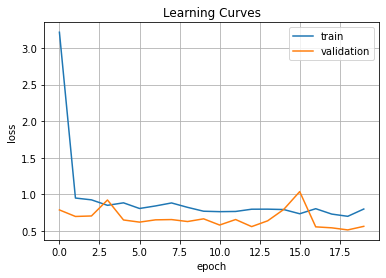

In [28]:
plt.plot(range(20),history3.history['loss'])
plt.plot(range(20),history3.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [29]:
history3.history['loss']

[3.2137293815612793,
 0.9515960812568665,
 0.9269640445709229,
 0.8520886301994324,
 0.8861936926841736,
 0.8090840578079224,
 0.843792736530304,
 0.8847336769104004,
 0.8245459198951721,
 0.7717190980911255,
 0.7657887935638428,
 0.768481433391571,
 0.7991607785224915,
 0.7998943328857422,
 0.7948523759841919,
 0.7371650338172913,
 0.8061773180961609,
 0.7327110767364502,
 0.702242910861969,
 0.8017376661300659]

In [30]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history3.history['loss'][-1], history3.history['val_loss'][-1]))

final MSE for train is 0.80 and for validation is 0.57


In [31]:
test_loss3 = estimator3.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss3)

46/46 [==============================] - 0s 758us/step - loss: 0.5583
test set mse is 0.56


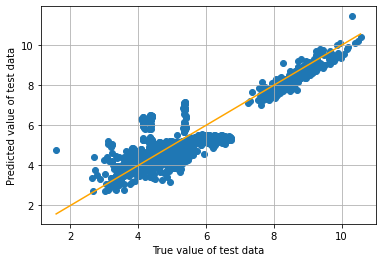

In [32]:
y_test_predict3 = estimator3.predict(x_test_norm)
plt.scatter(y_test, y_test_predict3)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

### Exercise 2:
* Please try some other learning rate value. Is it always better to have larger learning rate? Please explain. 

#### Finding the optimal Learning Rate 

In [139]:
#!pip install keras-tuner
import keras_tuner as kt

In [110]:
def nnmodel5(hp):
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    #optimizer = keras.optimizers.Adam(lr=0.05)
    hp_learning_rate = hp.Choice('learning_rate', values=[1.0,5e-1,1e-1,5e-2,1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',metrics=[keras.metrics.MeanSquaredError()])
    #model.compile(loss='mean_squared_error', optimizer=optimizer)
    #metrics=[keras.metrics.MeanAbsoluteError()]
    return model

In [117]:
tuner = kt.Hyperband(nnmodel5, # the hypermodel
                     objective=kt.Objective("val_mean_squared_error", direction="min"),
max_epochs=30,
factor=2,
directory='dir', # directory to save logs   
                     overwrite=True,
project_name='qm7b_e1zindo_tuner_accuracy3')
#factor=3, # factor which you have seen above 
# objective='val_accuracy', # objective to optimize
#overwrite=True,  

In [118]:
tuner.search_space_summary() 

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 1.0, 'conditions': [], 'values': [1.0, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0001], 'ordered': True}


In [119]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0
# Perform hypertuning
tuner.search(x_train_norm, y_train, epochs=20, validation_split=0.33, batch_size=32)

Trial 7 Complete [00h 00m 01s]
val_mean_squared_error: 19.391719818115234

Best val_mean_squared_error So Far: 0.6423189043998718
Total elapsed time: 00h 00m 07s
INFO:tensorflow:Oracle triggered exit


 The summary of the tuner based on different values of learning rate 

In [144]:
tuner.results_summary()

Results summary
Results in dir/qm7b_e1zindo_tuner_accuracy3
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.05
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6423189043998718
Trial summary
Hyperparameters:
learning_rate: 0.1
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.7394142746925354
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.7780057787895203
Trial summary
Hyperparameters:
learning_rate: 0.5
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.8453770875930786
Trial summary
Hyperparameters:
learning_rate: 1.0
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 3.4120640754699707
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 19.391719818115234
Trial summary
Hyperparameters:


Optimal learning rate value

In [145]:
tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.05,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [125]:
best_lr =tuner.get_best_hyperparameters()[0]

In [127]:
nnmodel_optim_lr = tuner.hypermodel.build(best_lr)

In [129]:
nnmodel_optim_lr.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [132]:
history5 = nnmodel_optim_lr.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

In [133]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history5.history['loss'][-1], history5.history['val_loss'][-1]))

final MSE for train is 0.72 and for validation is 0.55


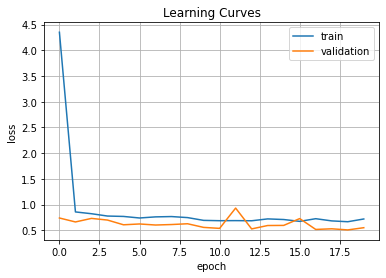

In [141]:
plt.plot(range(20),history5.history['loss'])
plt.plot(range(20),history5.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

Based on the graph, we might need to train it at higher epoch since neither curve are approaching stable state to determine how good the fit is. However, the model might be a good fit since both curves are close to each other. 

In [138]:
test_loss5 = nnmodel_optim_lr.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss5[1])
#test_loss5

46/46 [==============================] - 0s 729us/step - loss: 0.5456 - mean_squared_error: 0.5456
test set mse is 0.55


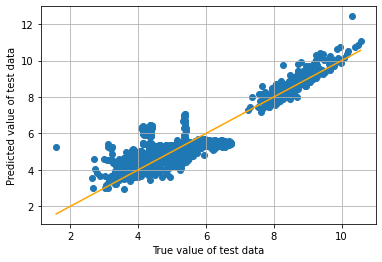

In [140]:
y_test_predict5 = nnmodel_optim_lr.predict(x_test_norm)
plt.scatter(y_test, y_test_predict5)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

#### Discussion 

The NN use gradient descent algorithm, which applied backpropagation method to update new weight. The learning rate controls how quick the model adapted to the problem within the backpropagation. If the learning rate is too large, the model might be able to converge much faster, but the solution might not be the optimal because it overshoots or undershoot from the optimal solution. If the learning rate is too small, we need to use more epoch to converge to the solution and possibly be overfitting due to high epoch number needed to update the weight at slower pace.

We can find the optimal learning rate value using keras-tuner. I set my tuner's objective to find lowest validation MSE, which is the score. 

We can see that the optimal learning rate is somewhere around 0.05. We can see that from the summary, higher learning rate will result in suboptimal result because the model converged too quickly. On the other hand, when we set the learning rate as low as 1e-4, the model is overfitting as seen from validation MSE. 

We might be able to improve the tuner model by including the training MSE as part of objective and see how the model reacts. Furthermore, we can try implement adaptive learning rate so that the model can adjust the learning rate as it trains. 

Source:
* Understand the Impact of Learning Rate on Neural Network Performance https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
* Understanding Learning Rate in Neural Networks https://www.allaboutcircuits.com/technical-articles/understanding-learning-rate-in-neural-networks/
* Getting started with KerasTuner https://keras.io/guides/keras_tuner/getting_started/
* Hyperparameter Tuning Of Neural Networks using Keras Tuner https://www.analyticsvidhya.com/blog/2021/08/hyperparameter-tuning-of-neural-networks-using-keras-tuner/


## Tune the number of layers
### Exercise 3: 
* Please add an extra hidden layer to the `nnmodel3`(the new layer will be right before the output layer).  The number of neurons, kernal initializer, and activation function of the new layer are up to your choice. Train the new model on the training data, and evaluate: final mse for train,validation, test set mse. Plot the learning curves, and analyze if your model is goodfit,overfit or underfit.  Make a scatter plot of predicted value of test data vs. true value of test data. 

In [146]:
def nnmodel4():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10 , kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    optimizer = keras.optimizers.Adam(lr=0.05)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [147]:
estimator4 = KerasRegressor(build_fn=nnmodel4)
history4 = estimator4.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

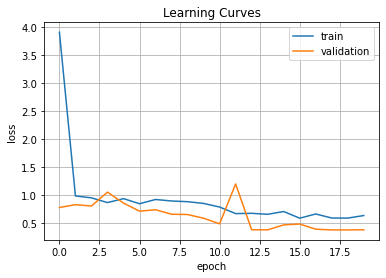

In [148]:
plt.plot(range(20),history4.history['loss'])
plt.plot(range(20),history4.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

Based on the learning curves, the model looks like overfitting because the training curve is increasing while the validation curve is stable. We might need to run a higher epoch to check that. 

In [149]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history4.history['loss'][-1], history4.history['val_loss'][-1]))

final MSE for train is 0.63 and for validation is 0.37


In [150]:
test_loss4 = estimator4.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss4)

46/46 [==============================] - 0s 680us/step - loss: 0.3883
test set mse is 0.39


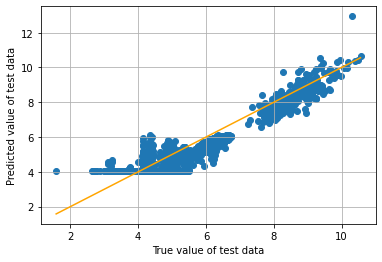

In [151]:
y_test_predict4 = estimator4.predict(x_test_norm)
plt.scatter(y_test, y_test_predict4)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

Based on parity plot, the NN did an okay job on predicting the test data.

### Resources:

* You may have noticed that the result is changing everytime even when you train the same model with the same data. 
You will need to set up some random seeds (shown below) to make the training process completely reproducible(i.e. to make the training loss and test mse exactly the same every time you run it). (You can refer to this page for more details: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development )


In [152]:
import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

* How to use Learning Curves to Diagnose Machine Learning Model Performance: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

* For more details about the Gradient Descent algorithm and learning rate, you can check out this article: https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3